# Notebook for Stanford GSB Technical Assessment

In [55]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Basic imports and functions used below
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import numpy as np
import pandas as pd
import os
import requests
from bs4 import BeautifulSoup , element as el
import statsmodels.api as sm
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
        
def mycdf( x , y , plotter , color=None , label=None , sort=False ) : 
    """ Custom CDF-style plotter for this assessment """
    if x.size != y.size : 
        raise ValueError("expect x and y to be the same size")
    # make "corners" in between points
    X , Y = np.zeros( 2*x.size-1 ) , np.zeros( 2*y.size-1 )
    if sort : 
        i = np.argsort( y )
        X[0::2] , Y[0::2] = x[i].copy() , y[i].copy()
    else : X[0::2] , Y[0::2] = x.copy() , y.copy()
    for n in range(0,x.size-1) : # can be done with an operation
        X[2*n+1] , Y[2*n+1] = X[2*(n+1)] , Y[2*n]
    if color is None : plotter( X , Y , linestyle='-' , label=label , linewidth='2' )
    else : plotter( X , Y , color=color , linestyle='-' , label=label , linewidth='2' )

def plot_season_bars( D , plotter , bar=None , ylim=[0,1] ) : 
    """ A function to create season bars on plots over time """
    d = pd.to_datetime( D )
    plotter( [d[0],d[0]] , ylim , '--k' )
    plotter( [d[1],d[1]] , ylim ,  ':k' )
    plotter( [d[2],d[2]] , ylim ,  ':k' )
    plotter( [d[3],d[3]] , ylim , '--k' )
    if bar is not None : 
        plotter( [d[0],d[3]] , bar*np.array([1,1]) , '--k' )
        
def plot_2015_season_bars( plotter , bar=None , ylim=[0,1] ) : 
    """ plot the 2015 season bars """
    plot_season_bars( ['2015/04/05','2015/10/06','2015/10/27','2015/11/01'] , plt.plot , bar=bar , ylim=ylim )
    
def plot_2016_season_bars( plotter , bar=None , ylim=[0,1] ) : 
    """ plot the 2016 season bars """
    plot_season_bars( ['2016/04/03','2016/10/04','2016/10/25','2016/11/03'] , plt.plot , bar=bar , ylim=ylim )

# load master file, as this is useful just about everywhere below (so far)
masterfile = "baseballdatabank-master/core/master.csv"
df_m = pd.read_csv( masterfile )
df_m.set_index( 'playerID' , drop=True , inplace=True )

# Q1

_Evaluate the Hall of Fame status of players as a result of country of origin for a faculty member's research project. Make a plot of players in the hall of fame over time, grouped by each country._

First we will read in two parts of the data set: the master file (above) and the Hall of Fame file. The master file has birth country and the hall of fame file has nomination year, induction (or not), and player or other role. We'll hack together a join over the playerID's by selecting over the right dataframe indices. Then we'll get counts by country using a groupby-count operation, and take cumulative sums. Then we can export the data (save as a csv file) as well as plot here. 

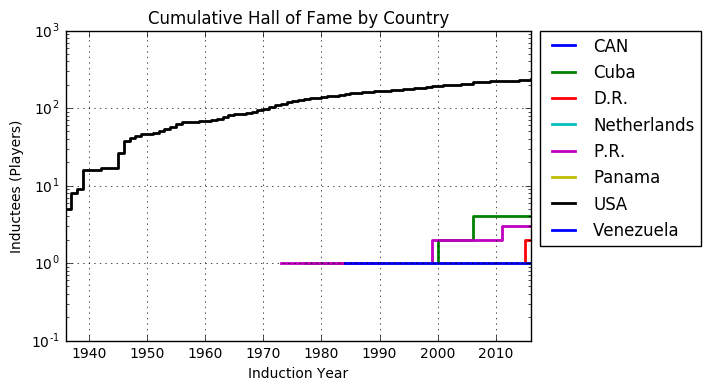

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for analysis and plotting related to the Hall of Fame. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# local path to the HOF file
hoffile = "baseballdatabank-master/core/HallOfFame.csv"

# read into a DataFrame
df_h = pd.read_csv( hoffile )
df_h = df_h[ df_h['category'] == 'Player' ] # focus here on player inductees
# df_h = df_h[ df_h['category'] != 'Player' ] # focus here on non-player inductees
df_h = df_h[ df_h['inducted'] == 'Y' ] # focus on actual inductions, not just nominations
df = df_h[['playerID','yearid']].copy()

# grab birth country in the "tmp" dataframe
df['birthCountry'] = df_m['birthCountry'].loc[ df['playerID'] ].values

# get an iterable list of * unique * birth countries in this data
bc = list( df_m['birthCountry'].unique() ) # list is iterable, though other ways exist of course

# use aggregation methods
df.sort_values( 'yearid' , axis=0 , inplace=True ) # make sure data is increasing in HOF data year
gdf = df.groupby(['yearid','birthCountry'])
adf = gdf['playerID'].agg( { 'count' : 'count' } ) # aggregation to count over year and country
adf.reset_index( inplace=True )
adf.sort_values( ['birthCountry','yearid'] , axis=0 , inplace=True )
adf.set_index( ['birthCountry','yearid'] , drop=True , inplace=True ) # last three steps "swap" the indices

# this initializes a "full" DataFrame for the cummulative data
bdf = pd.DataFrame( np.zeros((2017-1935,adf.index.levels[0].size)) , \
                    index=np.arange(1935,2017) , \
                    columns=adf.index.levels[0] )

# plot by country, also copying data into bdf for (verbose) write out
plt.grid( True , linestyle=':' )
for c in adf.index.levels[0] :
    try : 
        tmp = adf['count'].loc[c]
        bdf[c].loc[ tmp.index ] = tmp.values.copy()
        tmp[:] = np.cumsum( tmp.values )
        tmp.loc[2016] = np.max( tmp.values )
        # tmp.loc[1935] = 1.0e-16
        tmp.sort_index( inplace=True )
        mycdf( tmp.index , tmp.values , plt.semilogy , label=c )
        # plt.semilogy( tmp.index[0] , tmp.values[0] , marker='.' )
    except KeyError as e : 
        pass # print( 'Country %s not in HOF data' % c )
    except TypeError as e : 
        print( 'error (%s): %s' % (c,e) )

bdf = bdf.cumsum()
bdf.to_csv( "HallOfFameByBirthCountry.csv" )

plt.ylim( [0.1,1e3] )
plt.xlim( [1936,2016] )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
plt.title( 'Cumulative Hall of Fame by Country' )
plt.xlabel( 'Induction Year' )
plt.ylabel( 'Inductees (Players)' )

In [340]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Formatting for MetricsGraphics (easy way, following the examples). That is, interactive web graphics. 
# 
# NOTE: right now this doesn't appear to plot correctly in MetricsGraphics... Maybe in raw D3.js
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# for i in adf.index.levels[0] : print( adf.loc[i,:] )

f = open( "testout.json" , "w" )
f.write( '[\n' )
start = True
for i in adf.index.levels[0] : 
    
    tmp = adf.loc[i,:]
    tmp.sort_index( inplace=True )
    if int( tmp.index[-1] ) == 2016 : 
        Y , C = np.zeros( 2*tmp.shape[0]-1 ) , np.zeros( 2*tmp.shape[0]-1 )
    else : Y , C = np.zeros( 2*tmp.shape[0] ) , np.zeros( 2*tmp.shape[0] )
    Y[0::2] , C[0::2] = np.array( tmp.index ) , tmp.values.flatten()
    for n in range(0,tmp.shape[0]-1) : # can be done with an operation
        Y[2*n+1] , C[2*n+1] = Y[2*(n+1)] , C[2*n]
    if int( tmp.index[-1] ) < 2016 : 
        Y[-1] , C[-1] = 2016 , C[-2]
    
    # test plot to make sure we're writing out the right array
    # plt.semilogy( Y , C , '-k' )
        
    # write out portion
    if start : 
        f.write('\t[')
        start = False
    else: f.write( ',\n\t[' )
    f.write( "{" + "\"date\":\"" + ( "%i" % Y[0] ) + "-01-01\",\"value\":" + ( "%i" % C[0] ) + "}" )
    for n in range(1,Y.size) : 
        f.write( ",{" + "\"date\":\"" + ( "%i" % Y[n] ) + "-01-01\",\"value\":" + ( "%i" % C[n] ) + "}" )
    f.write( ']' )
    
f.write('\n]')
f.close()

# TBD: write a csv version for MetricsGraphics, D3.js testing


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# End Q1
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Q2

_What questions would you ask as follow ups?_

I think I would ask basic questions about deliverables: 

1. Is this the sort of thing you're looking for? 
2. Did we understand the data well enough? Miss any important subtleties about the field, baseball (I very well might)? 
3. Is the plot ok? Need a different image format, or different style (e.g., D3.js graphic?) 
4. Is the data itself useful? That is, the aggregated data in csv format. 

Basically, does this work adequately support you, and what else needs to be done (being careful about what is revision versus what is a new project). 

But I am mainly interested in asking: "What is the purpose of the analysis?" That isn't particularly specific, so I thought of the following: 

1. Are you interested in _likelihood_ of Hall of Fame nomination and/or induction for players by country? 
2. Hall of Fame nomination/induction for non-player roles by country? 
3. Hall of Fame nominee/inductee by performance, and whether that depends on country? 

I guess all these questions are leaning towards: _Are there country-specific disparities leading to nomination/induction?_

Also, what actual statistics are relevant? That is, I can envision modeling things like the probability of nomination given "performance" and country, and looking for "significant" effects on country, although the large bias towards US players in the data makes that touchy. Grouping (e.g., US, not US) might be an option there. Or, modeling probability of induction given nomination as a function of country. 

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# likelihood? How would we assess this? 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

gdf = df_m.groupby( ['birthCountry'] )


In [123]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# repeated nominations? 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

hoffile = "baseballdatabank-master/core/HallOfFame.csv"

df_h = pd.read_csv( hoffile )
df_h = df_h[ df_h['category'] == 'Player' ] # focus here on player inductees
# df_h = df_h[ df_h['category'] != 'Player' ] # focus here on non-player inductees
df_h['birthCountry'] = df_m['birthCountry'].loc[ df_h['playerID'] ].values

print( 'Number of unique player nominations: %i' % df_h['playerID'].unique().shape[0] )
print( 'Number of total nominations: %i' % df_h.shape[0] )

# converting to a dummy variable allows for the aggregation operation below
df_h['inducted_dummy'] = df_h['inducted'].apply( lambda x : 1 if x == 'Y' else 0 )
df_h['inducted'] = df_h['inducted_dummy'] * df_h['yearid']

gdf = df_h.groupby( 'playerID' )
adf = gdf['inducted'].agg( { 'nominations' : 'count' , 'inducted' : max } )
adf['birthCountry'] = df_m['birthCountry'].loc[ adf.index ].values
bdf = gdf['yearid'].agg( { 'firstNom' : min , 'lastNom' : max } )
adf['firstNom'] = bdf['firstNom']
adf['lastNom'] = bdf['lastNom']


Number of unique player nominations: 1189
Number of total nominations: 3997


In [124]:
# If we need debut year and years active, this set of commands gives us that

# print( df_m.groupby( 'birthCountry' ).count() )
# df_m['debut_year'] = df_m['debut']
df_m['debut'] = pd.to_datetime( df_m['debut'] )
df_m['finalGame'] = pd.to_datetime( df_m['finalGame'] )

try: del df
except : pass

df = df_m[['birthCountry','debut','finalGame']].copy()
df['debut_year']  = df['debut'].dt.year
# df['debut_month'] = df['debut'].dt.month
# df['debut_day']   = df['debut'].dt.day
df['final_year']  = df['finalGame'].dt.year
# df['final_month'] = df['finalGame'].dt.month
# df['final_day']   = df['finalGame'].dt.day
df = df.drop(['debut','finalGame'],axis=1)
df['activeYears'] = df['final_year'] - df['debut_year'] + 1

gdf = df.groupby( ['birthCountry','debut_year'] )

# print( df )


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# End Q2
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Q3

_The same faculty member is investigating popularity of players based on a number of different approaches, but is especially interested in visits and/or edits of player Wikipedia pages.  Produce a plot of the most popular players by time in a way that feels descriptive and compelling to you._

I'm more interested in views than edits, but either is possible. My process is to use multiple platforms and steps:

1. I use python (here) to create a list of player names stored in a single file as they would be formatted for Wikipedia pages. For example, "Mark McGuire" as "Mark_McGuire". I also use python to test URLs at Wikipedia using this simple formatting, via the requests module and "head" method (just get header and check status code). 
2. I then use the [Pageviews API](https://wikitech.wikimedia.org/wiki/Analytics/PageviewAPI) via a bash shell using the `curl` utility. This will enable (bash) scripting queries to Wikipedia about pageviews, but appears to only have data from July 2015 onward (for these pages). 
3. To better parse and package the data, I wrote a program in C, "wikipiper", that can be used in the shell via "`curl <url> | ./wikipiper(.exe) <options>`". This program extracts view data from a query result, storing it along with a time stamp. 
4. This data can then be read in in python, specifically here in jupyter, as a datafile along with other files. 

__WARNING__: Some of this analysis takes a bit of time to run, so be careful if repeating. 

#### Details: 

1. We have to be careful about names with multiple pages, such as "Michael Jackson". For this we check both `<name>` and `<name>_(baseball)` and take the latter if both return with status 200. 
2. We have to be careful about duplicate name constructs here, because of the basic info in the spreadsheets. I see 655 (out of 18,846) duplicates with the basic page naming construct. 

#### From Wikipedia Directly

Alternatively, I've also searched through the Wikipedia page for [Baseball Player Lists](https://en.wikipedia.org/wiki/Category:Lists_of_Major_League_Baseball_players), which points to pages such as [this](https://en.wikipedia.org/wiki/List_of_Major_League_Baseball_players_(A)). 

1. I used [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to pull out links to player pages. 
2. I then extracted the page names and constructing queries to the Pageviews API much like above. 
3. To run the queries (and do something different) I launched an [AWS EC2 instance](http://docs.aws.amazon.com/AWSEC2/latest/UserGuide/concepts.html) and ran the bash script and wikipiper code from there. 
4. The resulting data files, downloaded from AWS, are compiled here in python into a DataFrame. 

#### Caveats:

1. We should be careful about using this data "naively." I've ran for views from all agents, for example,  but we may want to restrict to views from users only. We may also want to cross-reference against the revision history, to separate views related to revision from views related to general interest. 
2. Other data is available in [archives](https://dumps.wikimedia.org/other/pagecounts-raw), however that would take more work to trawl through for these specific results. 


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for Wikipedia URL checking. 
# 
# HTTP status codes reviewed at: http://www.restapitutorial.com/httpstatuscodes.html
# 
# WARNING: DO NOT REPEATEDLY RUN; this takes time. Load dataframe from WikiURLs.csv instead. 
# 
# NOTE: where is the copy of a slice? 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import requests

URLs = pd.DataFrame( np.zeros( (df_m.shape[0],2) ) , columns=['url','status'] , index=df_m.index )
URLs['url'] = ( 'https://en.wikipedia.org/wiki/' + df_m['nameFirst'] + '_' + df_m['nameLast'] ).copy()
URLs['url'] = URLs['url'].str.replace( ' ' , '_' ) # replace (other) white space with an underscore
URLs['url'] = URLs['url'].str.replace( '\'' , '%27' ) # replace apostrophes with HTTP code

URLs['status'] = 404 * np.ones( URLs.shape[0] ) # initialize to no valid site

for u in range(0,URLs.shape[0]) : 
    try : 
        r = requests.head( URLs['url'].iloc[u] )
        URLs['status'].iloc[u] = r.status_code
    except Exception as e : 
        print( 'Exception encountered: url: %s (%s)' % (URLs['url'].iloc[u],e) )

URLs.to_csv( "WikiURLs.csv" )


C:\Users\William\Anaconda3\envs\python3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [62]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for Wikipedia URL pulling. We read a pulled and cleaned list of wikipedia baseball  
# player page lists (wikiplayerlistlinks.txt) and extract information about player pages from each. This
# extraction relies on an assumption that player names are in a table in each list page, in the form
# 
#     <th ...><a href="..." title="..."> ... </a> ... 
# 
# or 
# 
#     <td ...><a href="..." title="..."> ... </a> ... 
# 
# That is, the names and links we want are the first child tags of either table header or table row tags. 
# 
# See also "wikiqueryconstruct.sh". There I've written a script to write a script using this output to
# run the pageview queries. Currently running on AWS. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

wpls = pd.read_csv( "wikiplayerlistlinks.txt" )
f = open( "wikiplayerpages.txt" , "w" )

for u in range(0,wpls.shape[0]) : 
    r = requests.get( wpls['urls'].iloc[u] )
    if r.status_code != 200 :
        print( "could not get %s (%i)" % ( wpls['urls'].iloc[u] , r.status_code ) )
    else : 
        print( "working on %s..." % wpls['urls'].iloc[u] )
        soup = BeautifulSoup( r.text , 'html.parser')
        rows = soup.find_all('tr')
        for l in rows : 
            for c in l.children : 
                if isinstance( c , el.Tag ) : 
                    if ( c.name == 'td' ) or ( c.name == 'th' ) : 
                        for d in c.children : 
                            if isinstance( d , el.Tag ) : 
                                if d.name == 'a' : 
                                    try : 
                                        f.write( str(d) + ",\"http://en.wikipedia.org" + d['href'] + "\"," + d.contents[0] + "\n" )
                                    except Exception as e : 
                                        print( "++ error in tag " , d )
                                        print( "++   " , e )
                                break
                        break
        
f.close()

In [61]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for revision of URLs; particularly, checking "<name>_(baseball)" as a valid URL and
# using that instead of the naive URL if so. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

URLs = pd.read_csv( "WikiURLs.csv" )

URLs['bstatus'] = 404 * np.ones( URLs.shape[0] ) # initialize to no valid site

for u in range(0,URLs.shape[0]) : 
    try : 
        newurl = URLs['url'].iloc[u] + "_(baseball)"
        r = requests.head( newurl )
        URLs['bstatus'].iloc[u] = r.status_code
        if u % 1000 == 0 : print( "up to %i / %i" % ( u , URLs.shape[0] ) )
    except Exception as e : 
        print( 'Exception encountered: url: %s (%s)' % (newurl,e) )

# URLs.to_csv( "WikiURLs.csv" )

In [142]:
ulst = pd.read_csv( 'httpstatuscodes_bball.csv' )
ulst.columns = ['curl']

# URLs.set_index('playerID',inplace=True,drop=True)

# print( URLs.loc[ ( URLs['status'] == 200 ) & ( URLs['bstatus'] == 200 ) ] )

# new script...


Duplicate entries in matched (baseball) URLs:  244


In [66]:
# this section writes a pull script for the pageviews API for these "<name>_(baseball)" URLs

TMP = URLs.loc[ ( URLs['status'] == 200 ) & ( URLs['bstatus'] == 200 ) ]
tmp = TMP.drop_duplicates( subset=['url'] , keep='first' )
print( "Duplicate entries in matched (baseball) URLs: " , TMP.shape[0] - tmp.shape[0] )

qbody = '\"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/'

f = open( 'wikiqueries-baseball.sh' , 'w' )
f.write( "#!/bin/bash\n" )
for u in range(0,tmp.shape[0]) : 
    #if ( URLs['status'].values[u] == 200 ) and ( URLs['bstatus'].values[u] == 200 ) : 
    try : 
        
        name = df_m['nameFirst'].loc[tmp.index[u]] + '_' + df_m['nameLast'].loc[tmp.index[u]] + '_(baseball)'
        name = name.replace( ' ' , '_' )
        name = name.replace( '\'' , '%27' )
        # NOTE: need to find a way to escape "bad" characters into HTTP values
        # currently this appears to work, but perhaps could be embedded right
        # in the dataframe. 

        query = 'curl ' + qbody \
                        + name \
                        + '/daily/2010010100/2016123100\" | ./wikipiper.exe pulled/' + tmp.index[u] + '_b' \
                        + '\n'

        f.write( query )
        
    except TypeError as e :
        print( e )
        
f.close()

In [69]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# This section used for interactive revision and checking 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

print( URLs.shape[0] , np.sum( URLs['status'].values == 200 ) , URLs.shape[0] - np.sum( URLs['status'].values == 200 ) )
print( URLs.shape[0] , np.sum( URLs['status'].values == 404 ) )
print( URLs['status'].unique() )

# URLs['url'].loc[ URLs['status'] == 404 ] = URLs['url'].loc[ URLs['status'] == 404 ].str.replace( '\'' , '%27' )
# print( URLs.loc[ URLs['status'] == 404 ] )

#for i in URLs.index[ URLs['status'] == 404 ] :
#    try : float( URLs['url'].loc[i] )
#    except Exception : 
#        r = requests.head(URLs['url'].loc[i])
#        print( URLs['url'].loc[i] , r.status_code )
#    else : pass
#    try : 
#        r = requests.head(URLs['url'].loc[i])
#        URLs['status'].loc[i] = r.status_code
#    except Exception as e : 
#        print( 'Exception encountered: url: %s (%s)' % (URLs['url'].iloc[i],e) )

# URLs.to_csv( "WikiURLs.csv" )

# print( df_m[['nameFirst','nameLast','nameGiven']].loc[ URLs['status'] == 404 ] )

18846 18755 91
18846 91
[ 200.  404.]


In [63]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Make bash script to run "curl <url> | ./wikipiper <file>" calls 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

qbody = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/'

f = open( 'wikiqueries.sh' , 'w' )
f.write( "#!/bin/bash\n" )
for u in range(0,URLs.shape[0]) : 
    if URLs['status'].iloc[u] == 200 : 
        
        name = df_m['nameFirst'].iloc[u] + '_' + df_m['nameLast'].iloc[u]
        name = name.replace( ' ' , '_' )
        name = name.replace( '\'' , '%27' )
        # NOTE: need to find a way to escape "bad" characters into HTTP values
        # currently this appears to work, but perhaps could be embedded right
        # in the dataframe. 
        
        query = 'curl ' + qbody \
                        + name \
                        + '/daily/2010010100/2016123100 | ./wikipiper.exe pulled/' + URLs.index[u] \
                        + '\n'
        f.write( query )
        
f.close()

In [87]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Read in files thus created, piling them into a single dataframe. Make sure you size the dataframe first, 
# though, to preallocate... appending would take forever. 
# 
# WARNING: DO NOT REPEATEDLY RUN; this takes time. Load dataframe from wikiviews.pkl instead. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

N = np.sum( URLs['status'] == 200 )

df = pd.read_csv( "pulled/aardsda01.csv" , names=['date','aardsda01'] )
df['date'] = pd.to_datetime( df['date'] )
df.set_index( ['date'] , drop=True , inplace=True )

D = df.shape[0] # hack, presumes full set of dates in this first file
pids = URLs.loc[ URLs['status'] == 200 ].index

DF = pd.DataFrame( np.zeros((D,N),dtype=np.float_) , index=df.index , columns=pids , dtype=np.float_ )

for u in range(0,URLs.shape[0]) : 
    if URLs['status'].iloc[u] == 200 : 
        pid = URLs.index[u]
        df = pd.read_csv( "pulled/" + pid + ".csv" , names=['date',pid] )
        df['date'] = pd.to_datetime( df['date'] )
        df.set_index( ['date'] , drop=True , inplace=True )
        DF[pid] = df.copy()

DF.to_pickle( "wikiviews.pkl" )

In [60]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Read in files thus created, piling them into a single dataframe. Make sure you size the dataframe first
# though, to preallocate... appending would take forever. 
# 
# Here we update with the "<name>_(baseball)" URLs. 
# 
# WARNING: DO NOT REPEATEDLY RUN. Load dataframe from wikiviews.pkl instead. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

N = np.sum( ( URLs['status'] == 200 ) & ( URLs['bstatus'] == 200 ) )

DF = pd.read_pickle( "wikiviews.pkl" )

df = pd.DataFrame( np.zeros( (DF.shape[0] , N) ) , \
                   index=DF.index , \
                   columns=URLs.loc[( URLs['status'] == 200 ) & ( URLs['bstatus'] == 200 )].index )

for p in df : 
    try : 
        tmp = pd.read_csv( "pulled/" + p + "_b.csv" , names=['date',p] )
        tmp['date'] = pd.to_datetime( tmp['date'] )
        tmp.set_index( ['date'] , drop=True , inplace=True )
        df[p] = tmp.copy()
    except Exception as e : 
        print( "Exception:" , e )
        print( "dropping column " , p )
        df.drop( p , axis=1 , inplace=True )

df.fillna( 0 , inplace=True )

for p in df : 
    DF[p] = df[p].copy()
    
DF.to_pickle( "wikiviews.pkl" )

In [13]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Read in Wikipedia page data, much like in the above. 
# 
# WARNING: DO NOT REPEATEDLY RUN. Load dataframe from wikiviews.pkl instead. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

rootdir = './wiki'

nf , cols = 0 , []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        cols.append( file )
        nf += 1
        
DF = pd.read_pickle( "wikiviews.pkl" )

df = pd.DataFrame( np.zeros((DF.shape[0],nf)) , index=DF.index , columns=cols )
for f in df :
    if df[f].sum() == 0 : # for revisions in case there are errors
        try : 
            tmp = pd.read_csv( "./wiki/" + f , names=['date','views'] )
            tmp['date'] = pd.to_datetime( tmp['date'] )
            tmp.set_index( ['date'] , drop=True , inplace=True )
            df[f].loc[ tmp.index ] = tmp.values
        except Exception as e : 
            print( "Exception:" , e )
            print( "dropping column " , f )
            df.drop( f , axis=1 , inplace=True )

df.fillna( 0 , inplace=True )

df.to_pickle( "wikipedia.pkl" )

C:\Users\William\Anaconda3\envs\python3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Exception: Unknown string format
dropping column  wiki.tar.gz


(array([ 735780.,  735842.,  735903.,  735964.,  736024.,  736085.,
         736146.,  736208.,  736269.]), <a list of 9 Text xticklabel objects>)

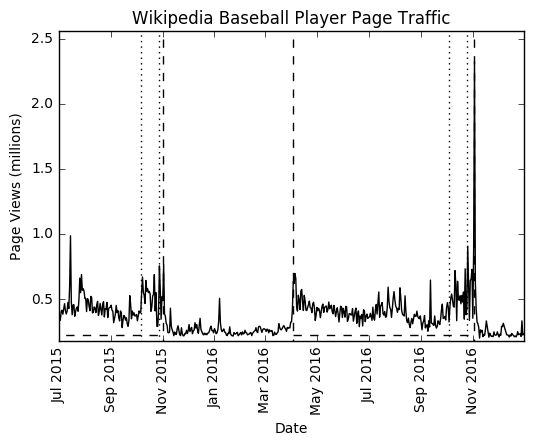

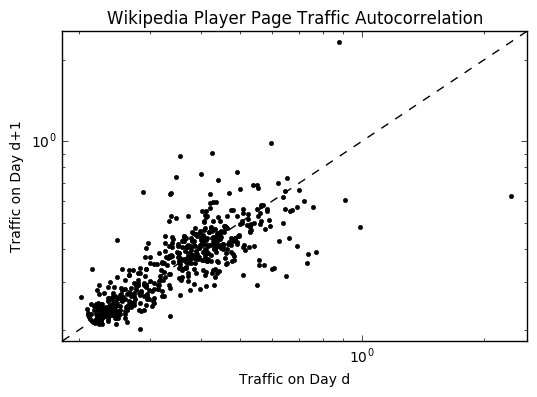

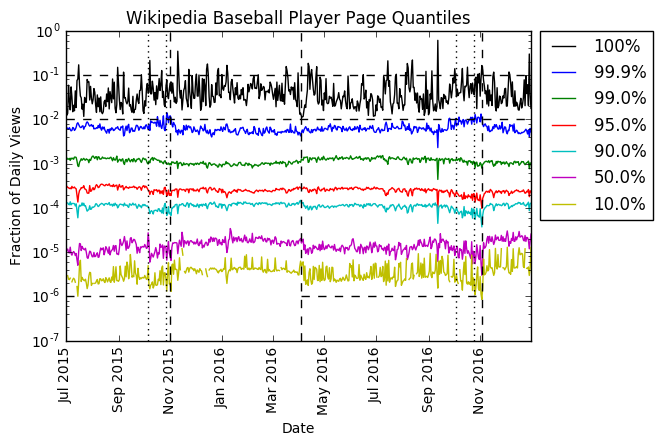

In [16]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Read in the dataframe with page views (since July 1st, 2015) and analyze...
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# DF = pd.read_pickle( "wikiviews.pkl" )
DF = pd.read_pickle( "wikipedia.pkl" )

# daily traffic ("views")
V = DF.sum( axis=1 ) / 1e6

plt.figure(1)
plt.plot( V , color='k' , linestyle='-' )
#plt.plot( V[ V.index.weekday < 5 ] , color='k' , linestyle='' , marker='.' )
#plt.plot( V[ V.index.weekday > 4 ] , color='r' , linestyle='' , marker='.' )
plot_2015_season_bars( plt.plot , bar=1.1*V.min() , ylim=[0,5] )
plot_2016_season_bars( plt.plot , bar=1.1*V.min() , ylim=[0,5] )
plt.xlim( [V.index[0],V.index[-1]] )
plt.ylim( [0.9*V.min(),1.1*V.max()] )
plt.title( 'Wikipedia Baseball Player Page Traffic' )
plt.xlabel( 'Date' )
plt.ylabel( 'Page Views (millions)' )
plt.xticks( rotation='vertical')

plt.figure(2)
plt.loglog( V.values[0:-1] , V.values[1:] , '.k' )
plt.loglog( [0.9*V.min(),1.1*V.max()] , [0.9*V.min(),1.1*V.max()] , '--k' )
plt.xlim( [0.9*V.min(),1.1*V.max()] )
plt.ylim( [0.9*V.min(),1.1*V.max()] )
plt.title( 'Wikipedia Player Page Traffic Autocorrelation' )
plt.xlabel( 'Traffic on Day d' )
plt.ylabel( 'Traffic on Day d+1' )

V = V * 1e6

# normalize by daily traffic
DF = DF.div( V , axis=0 )

Q = DF.quantile( np.array([99.9,99,95,90,50,10])/100.0 , axis=1 ).T

plt.figure(3)
plt.semilogy( DF.max( axis=1 ) , color='k' , label='100%' )
for c in Q.columns : 
    plt.semilogy( Q[c] , label=( "%0.1f%%" % (100.0*float(c)) ) )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
plt.semilogy( [DF.index[0],DF.index[-1]] , [0.1,0.1] , '--k' )
plt.semilogy( [DF.index[0],DF.index[-1]] , [0.01,0.01] , '--k' )
plot_2015_season_bars( plt.semilogy , bar=1e-6 , ylim=[1e-7,1e0] )
plot_2016_season_bars( plt.semilogy , bar=1e-6 , ylim=[1e-7,1e0] )
plt.xlim( [Q.index[0],Q.index[-1]] )
plt.ylim( [1e-7,1e0] )
plt.title( 'Wikipedia Baseball Player Page Quantiles' )
plt.xlabel( 'Date' )
# plt.grid( True )
plt.ylabel( 'Fraction of Daily Views' )
plt.xticks( rotation='vertical')


#### Some thoughts on the charts above. 

The top figure suggests that traffic is, as we would probably expect, (1) higher during the regular and post-season than in the off-season, (2) higher in the post-season than in the regular season, and (3) higher early in the regular season than later in the regular season. Formal tests of these observations would require multiple full years of page view data, not the 1 1/2 we have here. The large spike in player page views at the conclusion of the 2016 World Series can be further detailed, as below. This spike is probably due to the somewhat surprising win by the Chicago Cubs. 

The middle figure plots traffic in successive days, an illustration of likely autocorrelation in the data; for example, 

    V(d+1) = a V(d) + b + N(0,s^2)
    
We can see in this plot that there definitely appears to be some autocorrelation; the Pearson coefficient is about 0.6. If we were modeling this data, I would next look to run some formal tests on this aspect of the series. 

Finally, the bottom plot shows various daily quantiles of the per-player traffic fractions on a (base-10) log scale. That is, we have normalized player page views by total views (in each day) and take daily quantiles as listed in the legend. Dashed horizontal lines illustrate 1% and 10% of the daily traffic. What we can observe is that (1) some single page always has a full percent or more of daily traffic, (2) 99.9% of players _each_ have less than 1% of the daily traffic, and (3) the median daily traffic (over players) is less than 0.001% of all daily traffic. 


Correlation between V[d] and V[d+1]:  0.601361570041


(array([ 736240.,  736247.,  736254.,  736261.,  736268.,  736275.,
         736282.,  736289.,  736296.]), <a list of 9 Text xticklabel objects>)

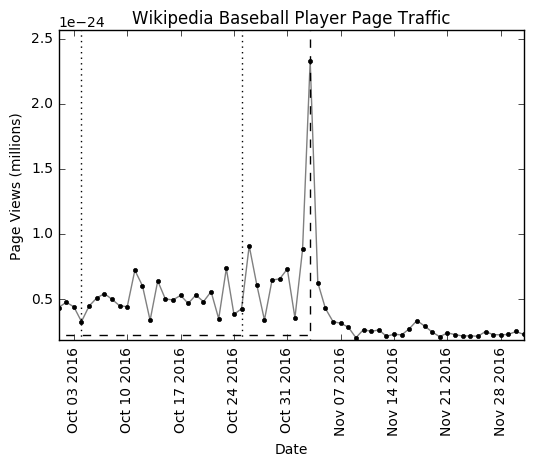

In [59]:
print( "Correlation between V[d] and V[d+1]: " , np.corrcoef( V[0:-1] , y=V[1:] )[0,1] )

V = V/1e6
plt.figure(1)
plt.plot( V , color=[0.5,0.5,0.5] , linestyle='-' )
plt.plot( V , color='k' , linestyle='' , marker='.' )
plot_2016_season_bars( plt.plot , bar=1.1*V.min() , ylim=[0,5] )
plt.xlim( pd.to_datetime(['2016/10/01','2016/12/01']) )
plt.ylim( [0.9*V.min(),1.1*V.max()] )
plt.title( 'Wikipedia Baseball Player Page Traffic' )
plt.xlabel( 'Date' )
plt.ylabel( 'Page Views (millions)' )
plt.xticks( rotation='vertical')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     136.7
Date:                Fri, 10 Mar 2017   Prob (F-statistic):           9.29e-81
Time:                        07:48:05   Log-Likelihood:                -86.023
No. Observations:                 549   AIC:                             182.0
Df Residuals:                     544   BIC:                             203.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3471      0.037      9.365      0.0

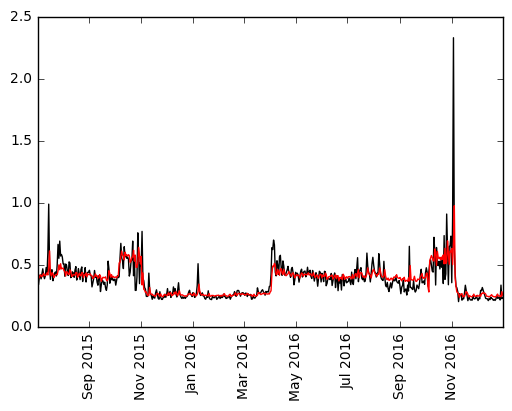

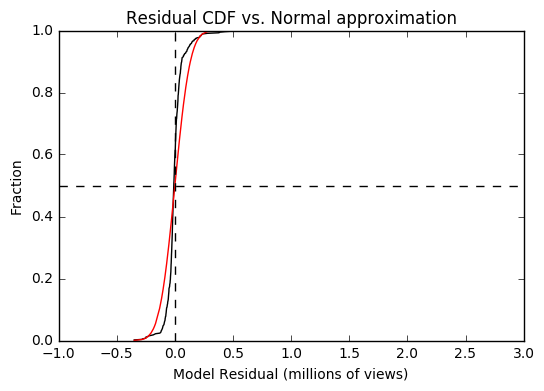

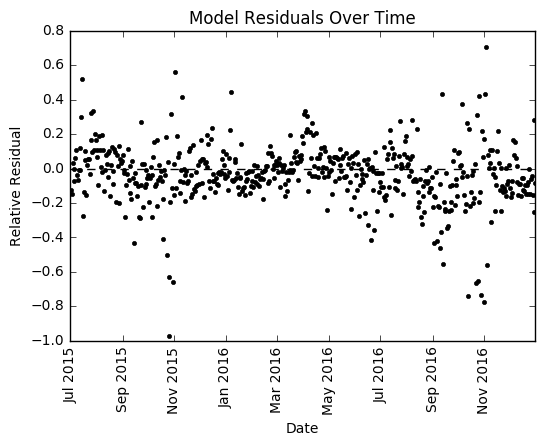

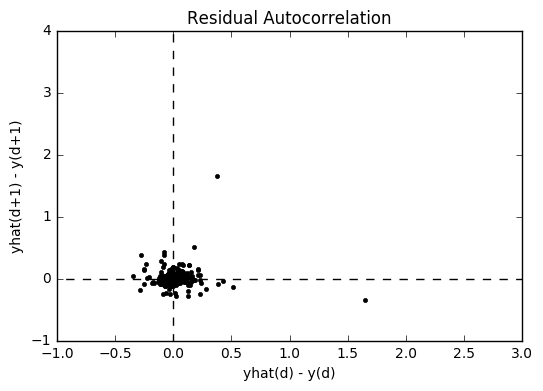

In [78]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Extra: simple modeling work for daily page view totals
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# DF = pd.read_pickle( "wikiviews.pkl" )
DF = pd.read_pickle( "wikipedia.pkl" )

# daily traffic ("views")
V = DF.sum( axis=1 ) / 1e6

N = V.shape[0]
S = np.log10( V.max() )

# make season dummies: off season is (0,0), regular is (1,0), post-season is (0,1)
s = np.zeros( (N-1,2) )
s[:,0] = np.logical_and( ( V.index[1:] > pd.to_datetime('2016/04/02') ) , ( V.index[1:] < pd.to_datetime('2016/10/04') ) )
s[:,0] = np.logical_or( ( V.index[1:] < pd.to_datetime('2015/10/06') ) , s[:,0] )
s[:,1] = np.logical_and( ( V.index[1:] > pd.to_datetime('2016/10/05') ) , ( V.index[1:] < pd.to_datetime('2016/11/04') ) )
s[:,1] = np.logical_or( np.logical_and( ( V.index[1:] > pd.to_datetime('2015/10/05') ) , ( V.index[1:] < pd.to_datetime('2015/11/02') ) ) , s[:,1] )

XD = np.hstack( ( V.values[0:-1].reshape((N-1,1)) / S , \
                  ( V.index.weekday[1:] > 4 ).reshape((N-1,1)) , \
                  s , 
                  np.ones((N-1,1)) ) )
yD = V.values[1:].copy() / S #.reshape((N-1,1))

R = sm.OLS( yD , XD ).fit()
print( R.summary() )

yhat = S * XD.dot( R.params )

plt.figure(1)
plt.plot( V.index[1:] , V.values[1:] , '-k' )
plt.plot( V.index[1:] , yhat , '-r' )
plt.xticks( rotation='vertical')

rhat = V.values[1:] - yhat
stdv = np.std( rhat )
print( 'Range, Expected, and STD for model error: [%0.2f,%0.2f] , %0.2f , %0.2f' % ( np.min( rhat ) , np.max( rhat ) , np.mean( rhat ) , stdv ) )

I    = np.argsort( rhat , axis=0 )
nres = norm.cdf(rhat,scale=stdv)

plt.figure(2)
plt.plot( rhat[I] , np.arange(1,N,1)/(N-1) , '-k' )
plt.plot( rhat[I] , nres[I] , '-r' )
plt.plot( [-1,3] , [0.5,0.5] , '--k' )
plt.plot( [0,0] , [0,1] , '--k' )
plt.title( 'Residual CDF vs. Normal approximation' )
plt.xlabel( 'Model Residual (millions of views)' )
plt.ylabel( 'Fraction' )

plt.figure(3)
plt.plot( V.index[1:] , rhat / V.values[1:] , '.k' )
plt.plot( [V.index[0],V.index[-1]] , [0,0] , '--k' )
plt.xticks( rotation='vertical')
plt.title( 'Model Residuals Over Time' )
plt.xlabel( 'Date' )
plt.ylabel( 'Relative Residual' )

plt.figure(4)
plt.plot( rhat[0:-1] , rhat[1:] , '.k' )
plt.plot( [-10,10] , [0,0] , '--k' )
plt.plot( [0,0] , [-10,10] , '--k' )
plt.xlim( [-1,3] )
plt.ylim( [-1,4] )
plt.title( 'Residual Autocorrelation' )
plt.xlabel( 'yhat(d) - y(d)' )
plt.ylabel( 'yhat(d+1) - y(d+1)' )

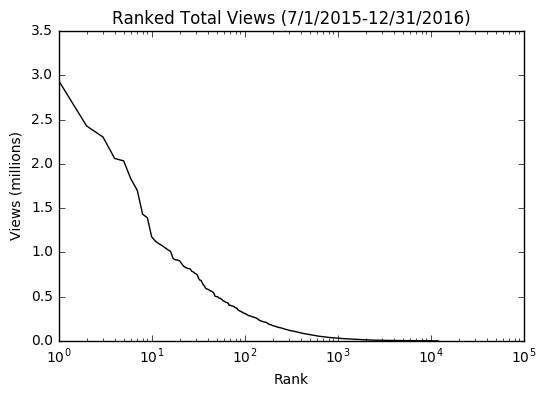

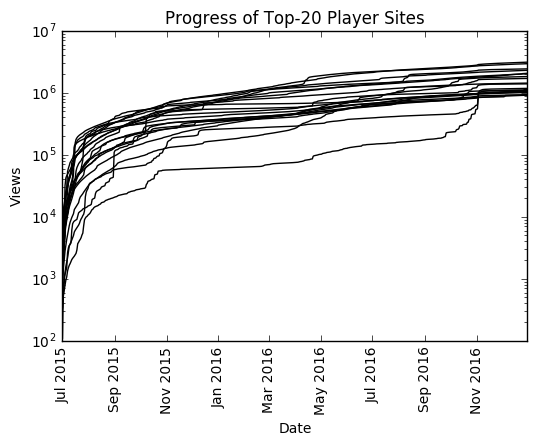

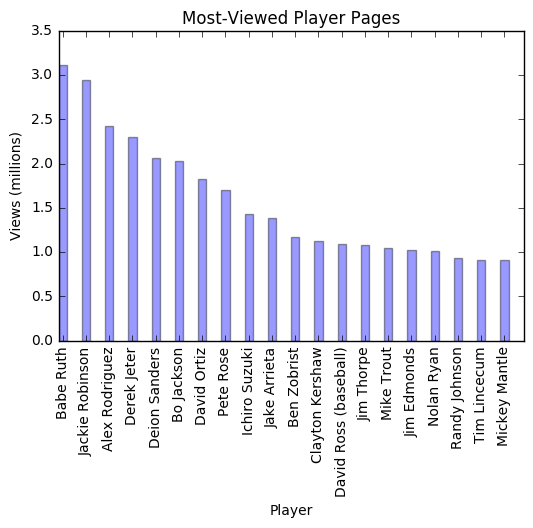

In [54]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Total views by player and ranking
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# DF = pd.read_pickle( "wikiviews.pkl" )
DF = pd.read_pickle( "wikipedia.pkl" )

S = DF.sum( axis=0 )
S.sort_values( inplace=True , ascending=False ) # highest sums first

plt.figure(1)
plt.semilogx( S.values / 1e6 , '-k' )
plt.title( 'Ranked Total Views (7/1/2015-12/31/2016)')
plt.ylabel( 'Views (millions)' )
plt.xlabel( 'Rank' )

plt.figure(2)
for p in list( S.index[0:20] ) : 
    # print( p.split(".")[0].replace( '_' , ' ' ) )
    # plt.semilogy( DF[p].rolling( center=True , window=30 ).mean() , '-k' )
    plt.semilogy( DF[p].cumsum() , '-k' )
plt.xticks( rotation="vertical" )
plt.title( 'Progress of Top-20 Player Sites' )
plt.xlabel( 'Date' )
plt.ylabel( 'Views' )

topN = 20
plt.figure(3)
index = np.arange(topN)
xlbls = [ x.split(".")[0].replace('_',' ') for x in S.index[0:topN].format() ]
# str.replace('_',' ')
bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}
rects1 = plt.bar(index, S[0:topN].values / 1e6 , bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config
                 )
plt.xticks( index + bar_width / 2, xlbls , rotation="vertical" )
plt.title('Most-Viewed Player Pages')
plt.xlabel('Player')
plt.ylabel('Views (millions)')
    

In [122]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# 
# Group the views dataframe by country of origin for "main" countries and "other". Currently "other" is 
# any country with less than 100 players. 
# 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

DF = pd.read_pickle( "wikiviews.pkl" )
DF.fillna( 0 , inplace=True )
DF = DF.div( DF.sum( axis=1 ) , axis=0 )

DF = DF.T
DF['birthCountry'] = df_m['birthCountry'].loc[DF.index].copy()

cc = df_m.groupby('birthCountry')['birthYear'].agg( {'count':'count'} )

DF.reset_index( inplace=True )

for c in cc.index : 
    if cc['count'].loc[c] < 100 : 
        DF['birthCountry'].loc[ DF['birthCountry'] == c ] = 'Other'

DF.sort_values( 'birthCountry' , axis=0 , inplace=True )
DF.set_index( ['birthCountry','playerID'] , drop=True , inplace=True )

DF.to_pickle( "wikiviews_bycountry.pkl" )

C:\Users\William\Anaconda3\envs\python3\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


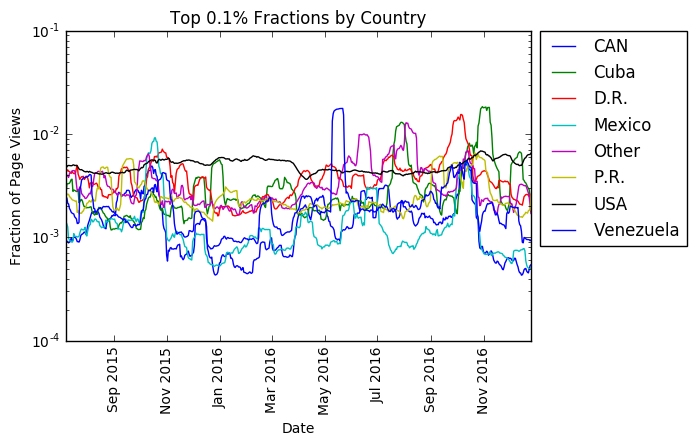

In [123]:

# if needed: 
# DF.read_pickle( "wikiviews_bycountry.pkl" )

for c in DF.index.levels[0] : 
    # plt.semilogy( DF.loc[c].quantile(0.999) , label=c )
    plt.semilogy( DF.loc[c].quantile(0.999).rolling( center=True , window=14 ).mean() , label=c )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
plt.xticks( rotation='vertical')
plt.title('Top 0.1% Fractions by Country')
plt.xlabel('Date')
plt.ylabel('Fraction of Page Views')

So, to me we need some kind of formal approach to "popularity". Let's say we rank player page views on each day, so that we create a table 

    VR[p,d] = player p's view rank on day d

Effectively, this table is defined by the condition

    DF[ inv(VR[:,d]) , d ] is in descending order
    
We can get that done with np.argsort, which returns inv(VR[:,d]), convertible to VR[:,d] by reindexing. 

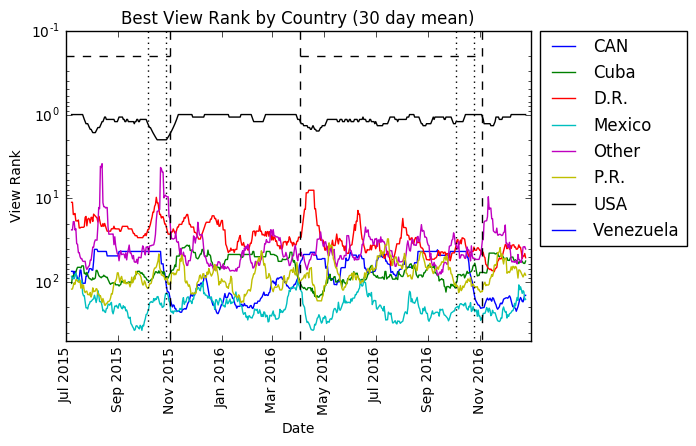

In [126]:
def rank_player_views( x ) :
    i = np.argsort(x) # x[i] will be in ascending order
    r = np.arange(0,x.size) + 1
    return r[i[::-1]]

def sort_with_ranks( x , r ) : 
    i = np.arange(0,x.size)
    return x[i[r-1]]

df = DF.apply( rank_player_views , axis=0 , raw=True )

# print( sort_with_ranks( DF[DF.columns[0]].values , df[df.columns[0]].values ) )

# df.reset_index( inplace=True )
gdf = df.groupby( level=[0] )
adf = gdf.min()

plt.figure(1)
for c in adf.index : 
    # plt.semilogy( adf.loc[c] , label=c )
    plt.semilogy( adf.loc[c].rolling( center=True , window=14 ).mean() , label=c )
plot_2015_season_bars( plt.semilogy , bar=0.2 , ylim=[0.1,1000] )
plot_2016_season_bars( plt.semilogy , bar=0.2 , ylim=[0.1,1000] )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
plt.ylim( [500,0.1] )
plt.xlim( [adf.columns[0],adf.columns[-1]] )
plt.xticks( rotation='vertical')
plt.title( 'Best View Rank by Country (30 day mean)' )
plt.ylabel( 'View Rank' )
plt.xlabel( 'Date' )


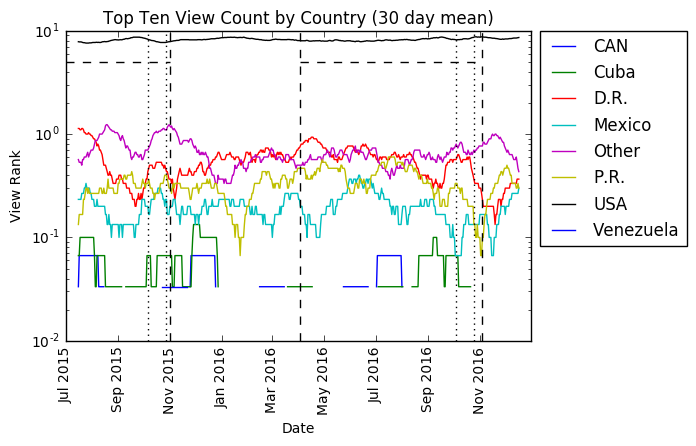

In [127]:

bdf = gdf.agg( lambda x : np.sum( x <= 10 ) )

# plt.figure(2)
for c in adf.index : 
    # plt.semilogy( bdf.loc[c] , label=c )
    plt.semilogy( bdf.loc[c].rolling( center=True , window=30 ).mean() , label=c )
plot_2015_season_bars( plt.semilogy , bar=5 , ylim=[1e-2,10] )
plot_2016_season_bars( plt.semilogy , bar=5 , ylim=[1e-2,10] )
plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
# plt.ylim( [10,0.5] )
plt.xlim( [adf.columns[0],adf.columns[-1]] )
plt.xticks( rotation='vertical')
plt.title( 'Top Ten View Count by Country (30 day mean)' )
plt.ylabel( 'View Rank' )
plt.xlabel( 'Date' )

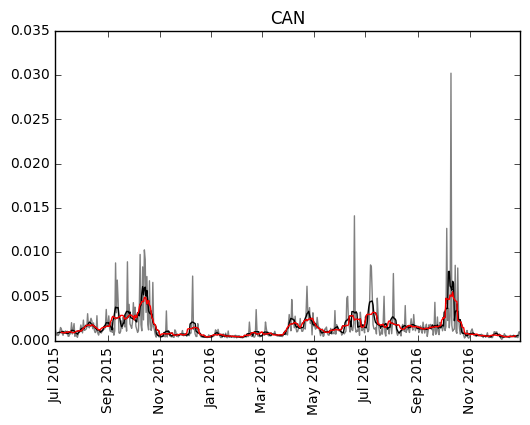

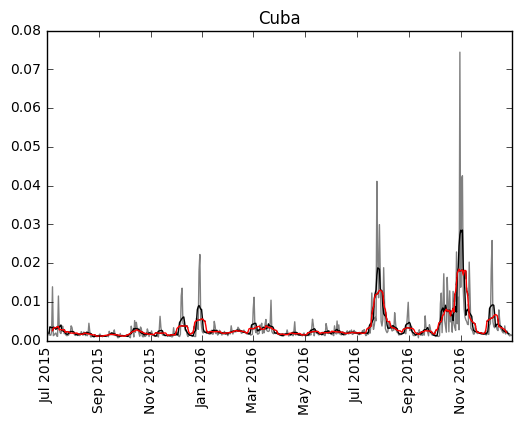

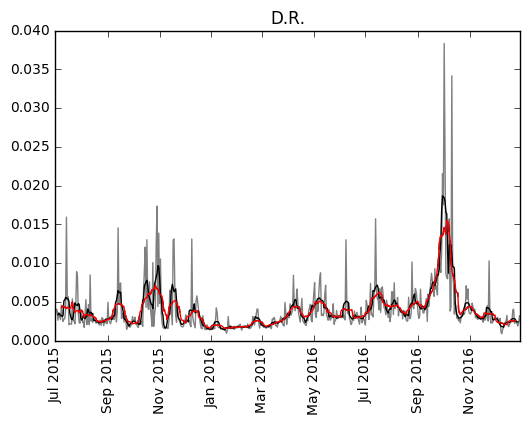

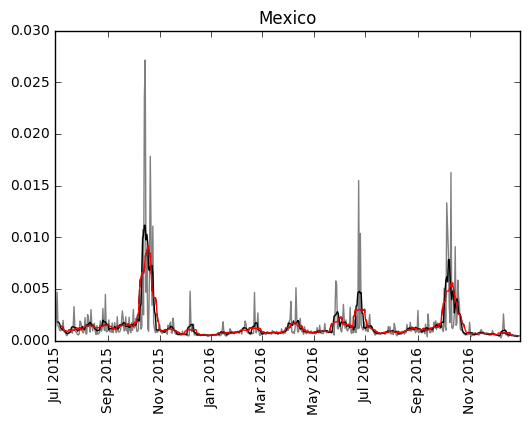

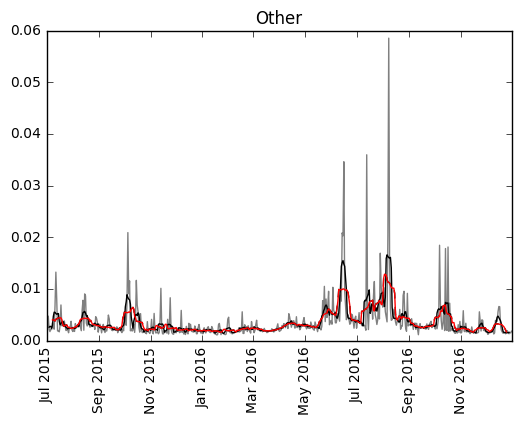

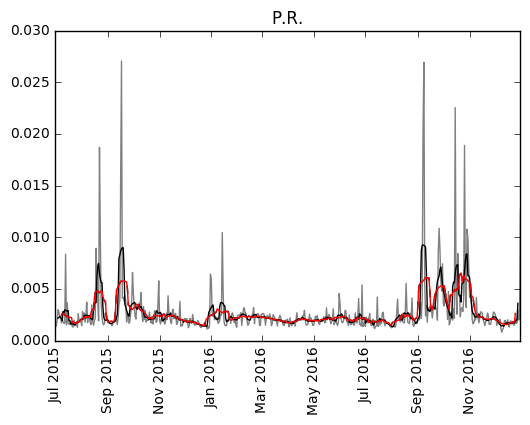

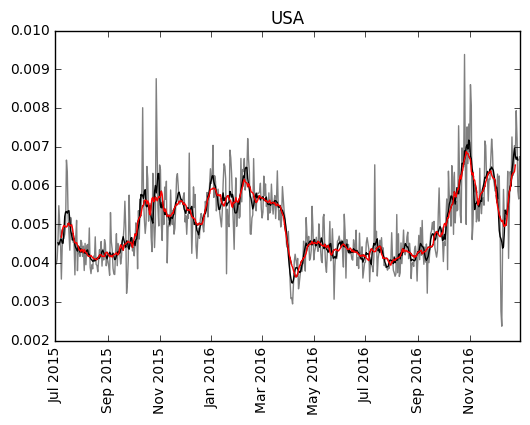

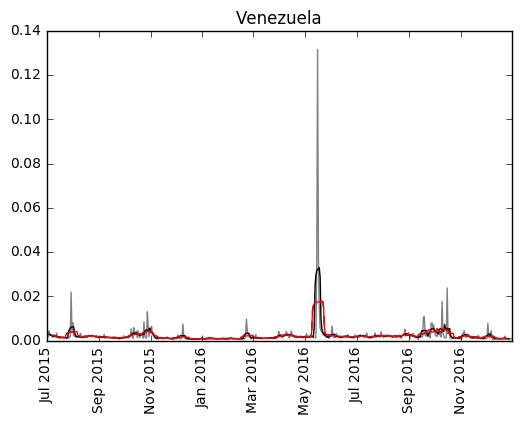

In [128]:
i = 0
for c in DF.index.levels[0] : 
    plt.figure(i)
    i += 1
    tmp = DF.loc[c].quantile(0.999)
    plt.plot( tmp , linestyle='-' , color=[0.5,0.5,0.5] )
    plt.plot( tmp.rolling( center=True , window=7  ).mean() , linestyle='-'  , color='k' )
    plt.plot( tmp.rolling( center=True , window=14 ).mean() , linestyle='--' , color='k' )
    plt.plot( tmp.rolling( center=True , window=14 ).mean() , linestyle='-'  , color='r' )
    # plt.legend( bbox_to_anchor=(1.02,1) , loc=2 , borderaxespad=0. )
    plt.xticks( rotation='vertical')
    plt.title( c )

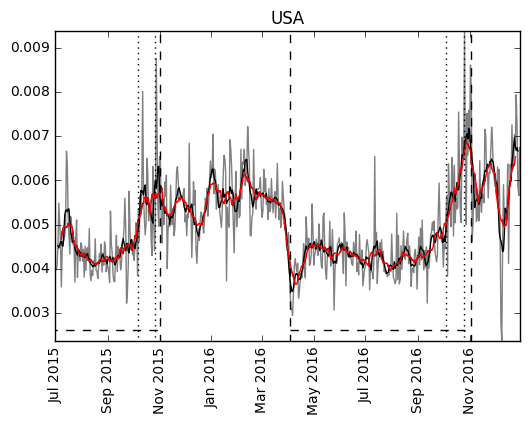

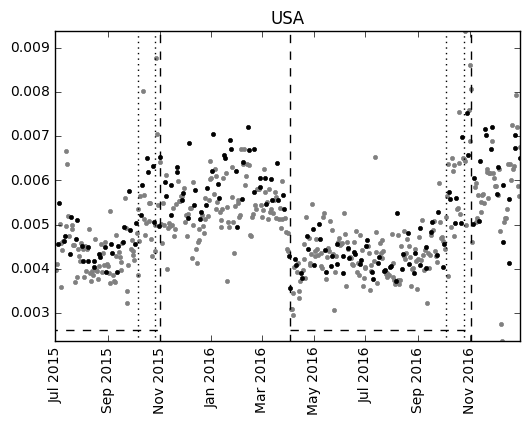

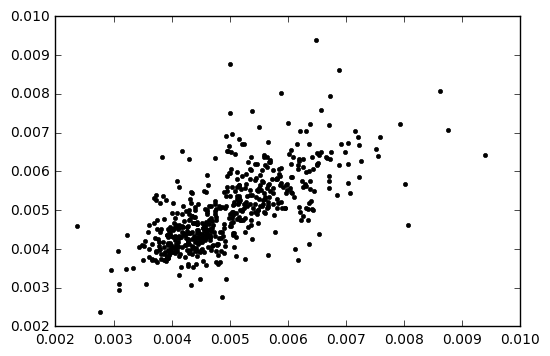

In [129]:
c = 'USA'

plt.figure(1)
tmp = DF.loc[c].quantile(0.999)
plt.plot( tmp , linestyle='-' , color=[0.5,0.5,0.5] )
plt.plot( tmp.rolling( center=True , window=7  ).mean() , linestyle='-'  , color='k' )
plt.plot( tmp.rolling( center=True , window=14 ).mean() , linestyle='--' , color='k' )
plt.plot( tmp.rolling( center=True , window=14 ).mean() , linestyle='-'  , color='r' )
plot_2015_season_bars( plt.plot , bar=1.1*tmp.min() )
plot_2016_season_bars( plt.plot , bar=1.1*tmp.min() )
plt.xlim([tmp.index[0],tmp.index[-1]])
plt.ylim([tmp.min(),tmp.max()])
plt.xticks( rotation='vertical')
plt.title( c )
#print( tmp.index.weekday < 5 )

plt.figure(2)
plt.plot( tmp[ tmp.index.weekday <  5 ] , marker='.' , linestyle='' , color=[0.5,0.5,0.5] )
plt.plot( tmp[ tmp.index.weekday >= 5 ] , marker='.' , linestyle='' , color='k' )
plot_2015_season_bars( plt.plot , bar=1.1*tmp.min() )
plot_2016_season_bars( plt.plot , bar=1.1*tmp.min() )
plt.xlim([tmp.index[0],tmp.index[-1]])
plt.ylim([tmp.min(),tmp.max()])
plt.xticks( rotation='vertical')
plt.title( c )

plt.figure(3)
plt.plot( tmp.values[0:-1] , tmp.values[1:] , marker='.' , linestyle='' , color='k' )
